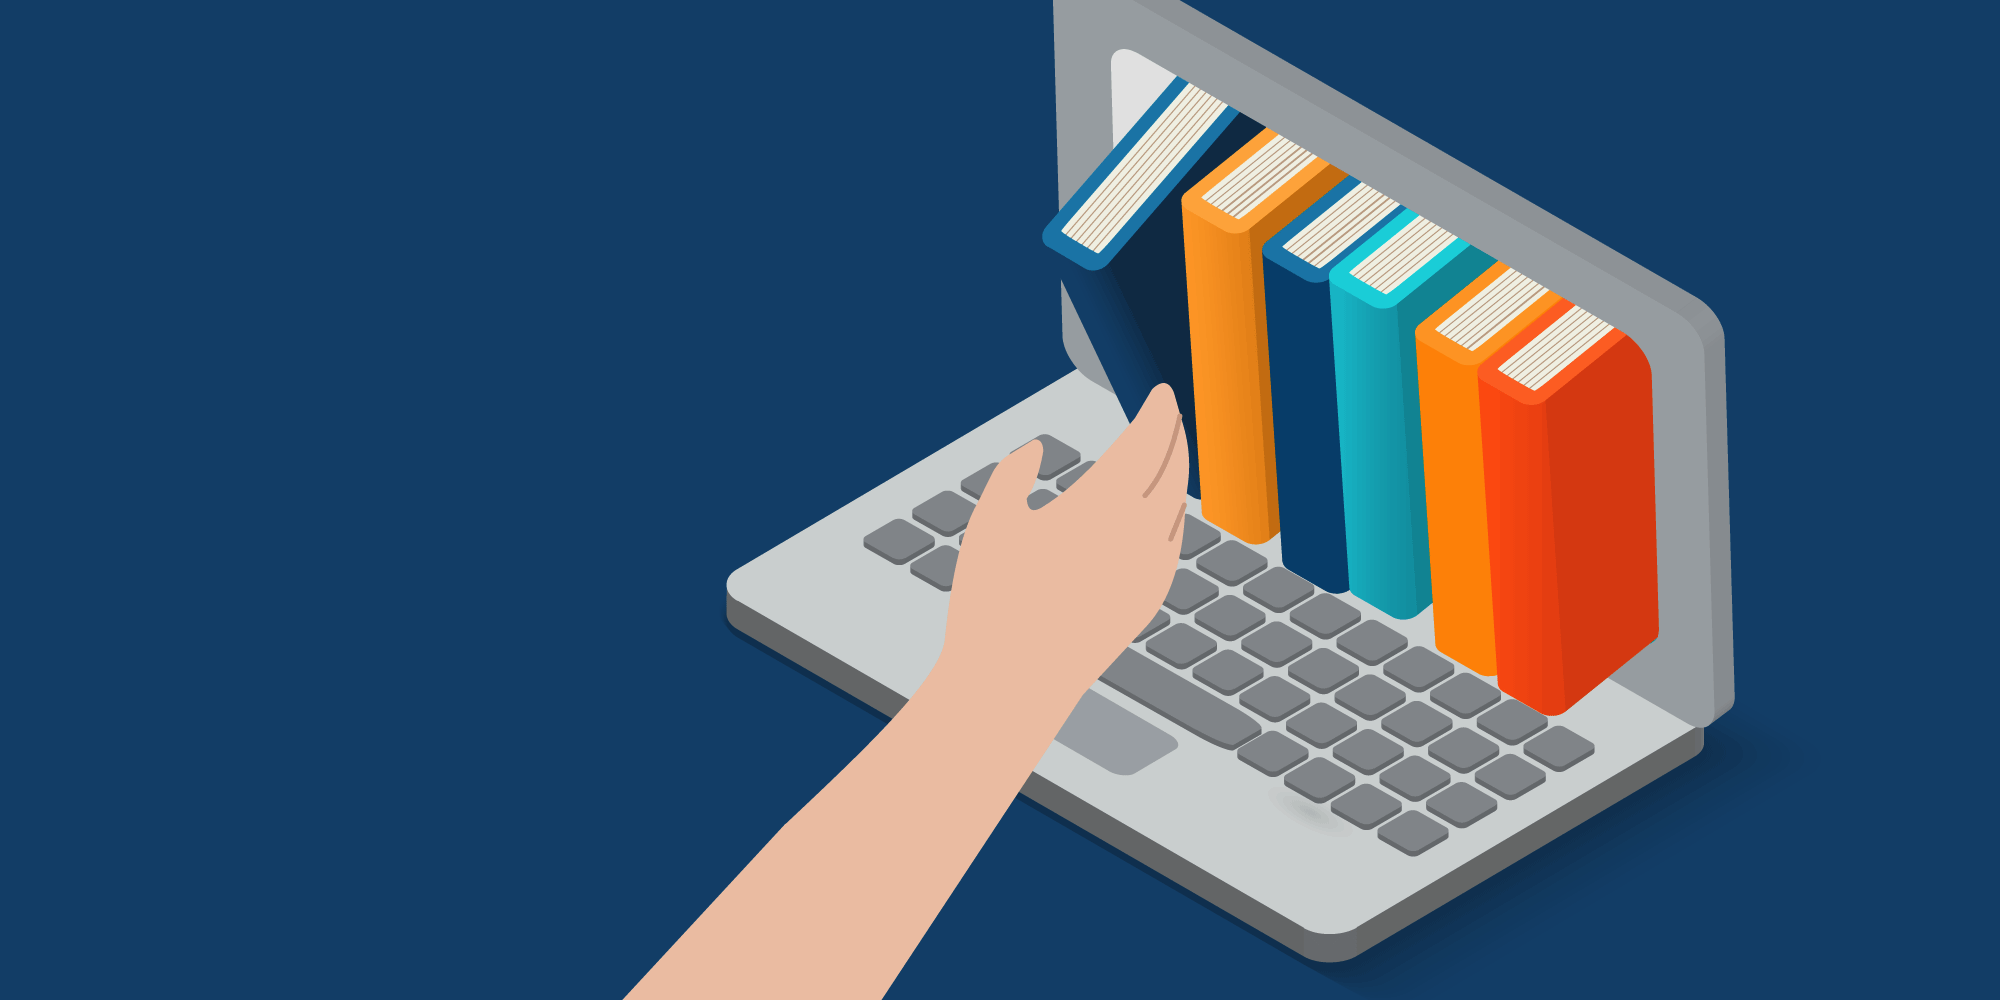

In [1]:
#Импортирую библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
#Считываю данные
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentAssessment = pd.read_csv('studentAssessment.csv')
studentRegistration = pd.read_csv('studentRegistration.csv')

In [3]:

studentAssessment.shape

(173912, 5)

In [4]:
assessments.shape

(206, 6)

In [5]:
studentAssessment.head()

id_assessment  id_student  date_submitted  is_banked  score
0           1752       11391              18          0   78.0
1           1752       28400              22          0   70.0
2           1752       31604              17          0   72.0
3           1752       32885              26          0   69.0
4           1752       38053              19          0   79.0

In [6]:
#Всего 173 null значения в оценках из 173912, не так много.
studentAssessment.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [7]:
#Нужно сджоинить таблицу с информацией об оценках в тесте с информацией о результатах тестирования студентов
full_assessment = studentAssessment.merge(assessments, how = 'left', on = 'id_assessment')

In [8]:
full_assessment.isnull().sum()

id_assessment           0
id_student              0
date_submitted          0
is_banked               0
score                 173
code_module             0
code_presentation       0
assessment_type         0
date                 2865
weight                  0
dtype: int64

In [9]:
full_assessment.describe()

id_assessment    id_student  date_submitted      is_banked  \
count  173912.000000  1.739120e+05   173912.000000  173912.000000   
mean    26553.803556  7.051507e+05      116.032942       0.010977   
std      8829.784254  5.523952e+05       71.484148       0.104194   
min      1752.000000  6.516000e+03      -11.000000       0.000000   
25%     15022.000000  5.044290e+05       51.000000       0.000000   
50%     25359.000000  5.852080e+05      116.000000       0.000000   
75%     34883.000000  6.344980e+05      173.000000       0.000000   
max     37443.000000  2.698588e+06      608.000000       1.000000   

               score           date         weight  
count  173739.000000  171047.000000  173912.000000  
mean       75.799573     130.605623      12.743899  
std        18.798107      78.025175      17.877301  
min         0.000000      12.000000       0.000000  
25%        65.000000      54.000000       0.000000  
50%        80.000000     129.000000       9.000000  
75%        90.000000     214.000000      18.000000  
max       100.000000     261.000000     100.000000

In [10]:
#Посмотрю на то, какое количество студентов завершило модули
completed_modules = (full_assessment.query("assessment_type == 'Exam' and score >= 40")
                                   .groupby(['code_module'], as_index = False)
                                   .agg(students = ('id_student', 'nunique'))
                                   .sort_values('code_module', ascending = False))

In [11]:
#Можно увидеть, что есть всего 2 модуля c экзаменами. DDD успешно закончило 2706 студентов, CCC - 1683
completed_modules

code_module  students
1         DDD      2706
0         CCC      1683

Можно заметить, что большинство студентов успешно завершают модуль.

In [12]:
#Теперь хочется понять какое количество тестов в семестре с разбивкой по предмету(модулю). 

assessments_count = (full_assessment.query("assessment_type !='Exam'") #Исключу экзамены, посмотрю только промежуточные
                                   .groupby(['code_presentation', 'code_module'],as_index = False)
                                   .agg(assessments_count = ('id_assessment', 'nunique'))
                                   .sort_values('assessments_count', ascending = False))

In [13]:
assessments_count.head()

code_presentation code_module  assessments_count
1              2013B         DDD                 13
2              2013B         FFF                 12
20             2014J         FFF                 12
13             2014B         FFF                 12
7              2013J         FFF                 12

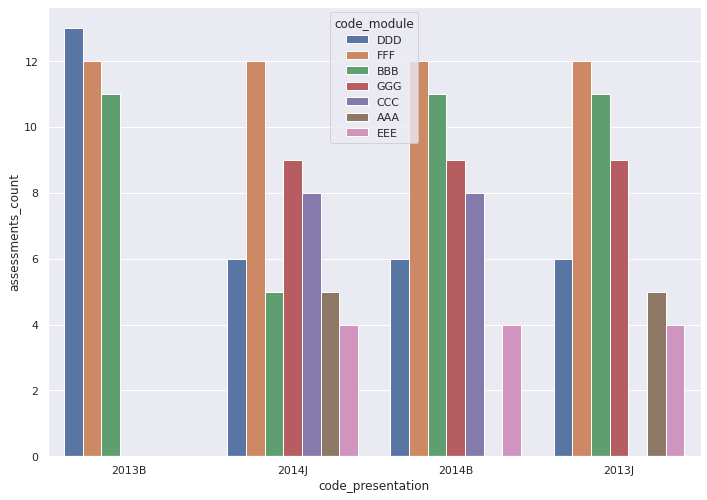

In [14]:
#Визуализирую полученную информацию
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = assessments_count,x = 'code_presentation', y = 'assessments_count', hue = 'code_module')

Можно заметить, что количество тестов по разным предметам по семестрам различается. Какие-то предметы (Например, DDD) являются базовыми и находятся во всех семестрах, какие-то предметы есть только в определенных семестрах. Выяснилось, что экзамены сдавались только по 2 предметам (DDD, CCC)

In [15]:
#Теперь посмотрю на количество студентов по семестрам. Таким образом я попытаюсь сгруппировать семестры в курс.

students_by_semester = (full_assessment.groupby('code_presentation', as_index = False)
                                       .agg(num_students = ('id_student', 'nunique'))
                                       .sort_values('num_students', ascending = False))


students_by_semester.head().head()

code_presentation  num_students
3             2014J          8613
1             2013J          7098
2             2014B          5748
0             2013B          3803

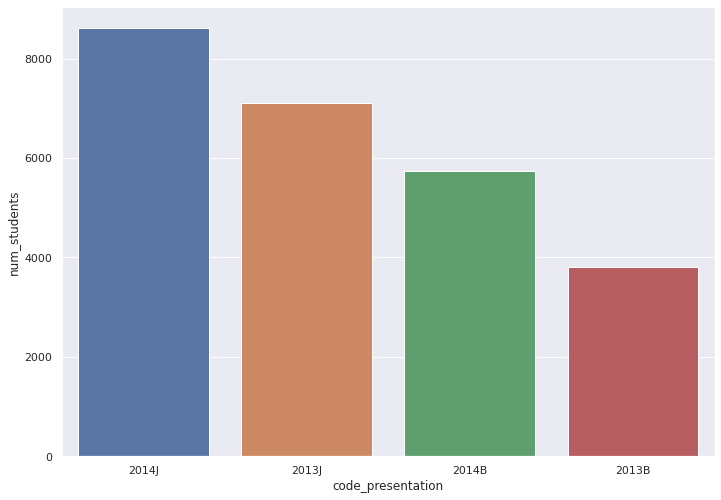

In [16]:
sns.barplot(data = students_by_semester, x = 'code_presentation', y = 'num_students')

Гипотеза: курс - сочетание двух семестров. У первого семестра на конце j, у второго - b. Это можно предположить исходя из того, что студентов j > b. Для проверки гипотезы можно посмотреть даты проведения экзаменов у студентов.

Возможно, курс состоит не из 2 семестров,а "семестр" - поток, а предметы внутри этого потока - курсы. 

In [17]:
#Смотрю на какие курсы зарегистрировался студент внутри семестра 
exams_registrations =  (studentRegistration.groupby(['code_presentation', 'code_module'],as_index = False)
                                   .agg(exams_registrations = ('date_registration', 'nunique')) 
                                   .sort_values('code_presentation', ascending = False))



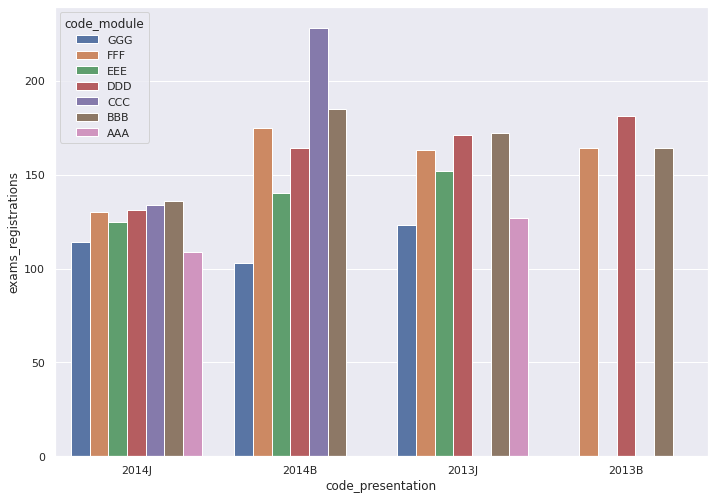

In [18]:
#Визуализирую полученную информацию
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = exams_registrations,x = 'code_presentation', y = 'exams_registrations', hue = 'code_module')

Это мало что дало


In [19]:
#Добавляю еще одну колонку, в которую помещаю сдан экзамен или нет
full_assessment['is_passed'] = np.where(full_assessment.score >= 40, 1, 0)

In [20]:
#Теперь посмотрю на то, какие экзамены успешно сдают студенты
successful_students = (full_assessment.query("assessment_type == 'Exam'")
                                     .groupby(['id_student', 'code_presentation', 'code_module'], as_index = False)
                                     .agg(exam_passed = ('is_passed', 'sum'))
                                     .sort_values('exam_passed', ascending = False))

In [21]:
#Строю на основе группировки сводную таблицу
successful_students_pivot = successful_students.pivot_table(index = 'id_student', 
                                                            columns = ['code_presentation', 'code_module'],
                                                            values= 'exam_passed', 
                                                            aggfunc=np.sum,
                                                            margins = True, 
                                                            margins_name='Total').fillna(0).reset_index()
                                                           
                                                           

In [22]:
successful_students_pivot[successful_students_pivot.Total > 1].head()

code_presentation id_student 2013B 2013J 2014B      2014J      Total
code_module                    DDD   DDD   CCC  DDD   CCC  DDD      
72                     80329   0.0   0.0   0.0  0.0   1.0  1.0     2
74                     80868   0.0   1.0   0.0  0.0   1.0  0.0     2
102                   105523   0.0   1.0   1.0  0.0   0.0  0.0     2
122                   123598   0.0   1.0   0.0  0.0   1.0  0.0     2
125                   126394   0.0   1.0   1.0  0.0   0.0  0.0     2

Исходя из данных о сдачи экзаменов я делаю следующее предположение: курс - это отдельный предмет в рамках семестра. Люди, которые сдают 2 курса, как правило, заканчивают 1 CCC и 1 DDD. Также делаю вывод, что для завершения курса достаточно успешно сдать экзамен по этому предмету в рамках семестра, т.к студенты восстанавилваются на этот же предмет, в семестр с такой же буквой, но на след. год (Например, закончил экз в 2013j, в 2014j восстановился на этот же предмет)

# Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).

In [23]:
#Количество студентов, которые успешно сдали только один предмет предмета. 
print(str(successful_students_pivot[successful_students_pivot.Total == 1].id_student.count()) + ' студентов успешно завершили только один курс')  

3802 студентов успешно завершили только один курс


# Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [24]:
#Для начала создам дф, в котором будут только экзамены
exams = full_assessment.query("assessment_type == 'Exam'")
exams.head()

id_assessment  id_student  date_submitted  is_banked  score  \
52923          24290      558914             230          0   32.0   
52924          24290      559706             234          0   78.0   
52925          24290      559770             230          0   54.0   
52926          24290      560114             230          0   64.0   
52927          24290      560311             234          0  100.0   

      code_module code_presentation assessment_type  date  weight  is_passed  
52923         CCC             2014B            Exam   NaN   100.0          0  
52924         CCC             2014B            Exam   NaN   100.0          1  
52925         CCC             2014B            Exam   NaN   100.0          1  
52926         CCC             2014B            Exam   NaN   100.0          1  
52927         CCC             2014B            Exam   NaN   100.0          1

In [25]:
#Посчитаю общее количество попыток сдать экзамен

all_tries = (exams.groupby(['code_presentation', 'code_module'], as_index = False)
                  .agg(count_all = ('id_assessment', 'count'))
                  .sort_values('count_all', ascending = False)
            )
all_tries

code_presentation code_module  count_all
4             2014J         CCC       1168
1             2013J         DDD        968
5             2014J         DDD        950
2             2014B         CCC        747
0             2013B         DDD        602
3             2014B         DDD        524

In [26]:
#Успешные сдачи экзаменов
successful_tries = (exams.query("is_passed == 1")
                         .groupby(['code_presentation', 'code_module'], as_index = False)
                         .agg(count_successful = ('id_assessment', 'count'))
                         .sort_values('count_successful', ascending = False)
                    )
successful_tries

code_presentation code_module  count_successful
4             2014J         CCC              1019
1             2013J         DDD               878
5             2014J         DDD               842
2             2014B         CCC               664
0             2013B         DDD               504
3             2014B         DDD               485

In [27]:
#Соединяю данные в один дф 
completion = all_tries.merge(successful_tries, how = 'left', on = ['code_presentation', 'code_module'])
completion.head()

code_presentation code_module  count_all  count_successful
0             2014J         CCC       1168              1019
1             2013J         DDD        968               878
2             2014J         DDD        950               842
3             2014B         CCC        747               664
4             2013B         DDD        602               504

In [28]:
#Рассчитаю завершаемость для каждого курса
completion['completion'] = completion.count_successful / completion.count_all

In [29]:
completion

code_presentation code_module  count_all  count_successful  completion
0             2014J         CCC       1168              1019    0.872432
1             2013J         DDD        968               878    0.907025
2             2014J         DDD        950               842    0.886316
3             2014B         CCC        747               664    0.888889
4             2013B         DDD        602               504    0.837209
5             2014B         DDD        524               485    0.925573

Самая низкая завершаемость у курса DDD из семестра 2013B, она составляет 0.84. Самая высокая же у курса DDD из семестра 2014B (0.93)

# По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

In [30]:
#Сдача экзамена - последнее успешное прохождение экзамена
exams.head()

id_assessment  id_student  date_submitted  is_banked  score  \
52923          24290      558914             230          0   32.0   
52924          24290      559706             234          0   78.0   
52925          24290      559770             230          0   54.0   
52926          24290      560114             230          0   64.0   
52927          24290      560311             234          0  100.0   

      code_module code_presentation assessment_type  date  weight  is_passed  
52923         CCC             2014B            Exam   NaN   100.0          0  
52924         CCC             2014B            Exam   NaN   100.0          1  
52925         CCC             2014B            Exam   NaN   100.0          1  
52926         CCC             2014B            Exam   NaN   100.0          1  
52927         CCC             2014B            Exam   NaN   100.0          1

In [31]:
retake = (exams.groupby(['id_student','code_module'] , as_index = False)
               .agg( minimal = ('is_passed', 'min'), passed= ('is_passed','sum')))

In [32]:
#Студенты, которые пересдавали предмет. Т.е пересдач нет, можно смело брать успешную сдачу экзамена
retake.query("minimal == 0 and passed == 1").head()

Empty DataFrame
Columns: [id_student, code_module, minimal, passed]
Index: []

In [33]:
#Определяю среднее значение и стандартное отклонение 
avg_passing_time = (exams.query("is_passed == 1")
                         .groupby('code_module', as_index = False)
                         .agg(mean_submitted = ('date_submitted', 'mean'), std = ('date_submitted', 'std'))
                         .sort_values('mean_submitted', ascending = False)
                   
                   
                   )

In [34]:
avg_passing_time.head()

code_module  mean_submitted       std
0         CCC      239.345217  6.650902
1         DDD      237.976006  4.942335

Среднее значение сдачи экзамена для предмета CCC составляет 239 дней, а для DDD - 238 дней. 

In [35]:
exams.head()

id_assessment  id_student  date_submitted  is_banked  score  \
52923          24290      558914             230          0   32.0   
52924          24290      559706             234          0   78.0   
52925          24290      559770             230          0   54.0   
52926          24290      560114             230          0   64.0   
52927          24290      560311             234          0  100.0   

      code_module code_presentation assessment_type  date  weight  is_passed  
52923         CCC             2014B            Exam   NaN   100.0          0  
52924         CCC             2014B            Exam   NaN   100.0          1  
52925         CCC             2014B            Exam   NaN   100.0          1  
52926         CCC             2014B            Exam   NaN   100.0          1  
52927         CCC             2014B            Exam   NaN   100.0          1

# Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

In [36]:
#Здесь нам потребуется таблица studentRegistration
top_reg = (studentRegistration.groupby('code_module', as_index = False)
                              .agg(count = ('code_module', 'count'))
                              .sort_values('count', ascending = False)
          )
top_reg.head(3)

code_module  count
1         BBB   7909
5         FFF   7762
3         DDD   6272

Топ 3 предмета по регистрации: BBB, FFF, DDD. Ниже визуализирую результат для всех предметов

In [37]:
#Посмотрю на топ 3 предмета по регистрации среди пользователей, которые не отменили регистрацию до начала семестра (Могли бы миссклики, кто-то передумал)
top_reg_completed = (studentRegistration.query("date_unregistration.isnull() or date_unregistration > 0")
                              .groupby('code_module', as_index = False)
                              .agg(count = ('code_module', 'count'))
                              .sort_values('count', ascending = False)
          )
top_reg_completed.head(3)

code_module  count
5         FFF   7069
1         BBB   6921
3         DDD   5676

Как видно из таблицы, топовые предметами остались все те же, но изменился порядок. Еслит считать среди не отмененных курсов, то самый популярный предмет - FFF

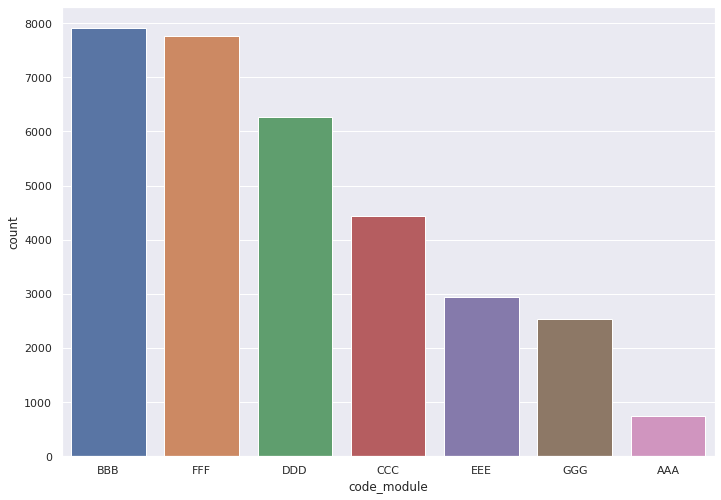

In [38]:
sns.barplot(data = top_reg, x = 'code_module', y = 'count')

Как видно из графика, чаще всего регистрируются на BBB, а реже всего на AAA.

Отток пользователей в e-learning можно рассчитать, используя следующую формулу:

Отток = (Количество пользователей, прекративших использование e-learning платформы / Общее количество пользователей) * 100%

Взять общее количество пользователей на курсе - легкая задача, можно просто взять количество регистраций. В качестве тех, кто прекратил обучение я возьму студентов, которые:

1. Отменили регистрацию
2. Не стали сдавать экзамен или сдали его на 0 баллов 
3. Не сдавали 

In [132]:
#Для начала посмотрб на какие предметы сколько людей регистрируется
top_reg

code_module  count
1         BBB   7909
5         FFF   7762
3         DDD   6272
2         CCC   4434
4         EEE   2934
6         GGG   2534
0         AAA    748

In [133]:
#Теперь возьму количество студентов, которые делали хоть что-то в модуле. 
# => Это те, кто не отменил регистрацию до начала курса и занимался на нем. 

active_students = full_assessment.groupby('code_module', as_index = False) \
                                 .agg(count_st = ('id_student', 'nunique')) \
                                 .sort_values('count_st', ascending = False)
active_students

code_module  count_st
5         FFF      6058
1         BBB      5960
3         DDD      4699
2         CCC      3318
4         EEE      2268
6         GGG      2107
0         AAA       677

In [134]:
#Теперь возьмем тех, кто отменил после начала 

cancelled = studentRegistration.query("date_unregistration > 0") \
                                .groupby("code_module", as_index = False) \
                                .agg(cancelled_cnt = ('id_student', 'nunique')) 
cancelled
                                    

code_module  cancelled_cnt
0         AAA             98
1         BBB           1355
2         CCC           1387
3         DDD           1531
4         EEE            469
5         FFF           1599
6         GGG            219

In [135]:
#Заджоиню
churn_rate = active_students.merge(cancelled, how = 'left', on = 'code_module')
churn_rate

code_module  count_st  cancelled_cnt
0         FFF      6058           1599
1         BBB      5960           1355
2         DDD      4699           1531
3         CCC      3318           1387
4         EEE      2268            469
5         GGG      2107            219
6         AAA       677             98

In [136]:
#Оставлю активных пользователей 
churn_rate['active_cnt'] =  churn_rate.count_st - churn_rate.cancelled_cnt
churn_rate = churn_rate[['code_module', 'active_cnt']]
churn_rate

code_module  active_cnt
0         FFF        4459
1         BBB        4605
2         DDD        3168
3         CCC        1931
4         EEE        1799
5         GGG        1888
6         AAA         579

In [137]:
#Теперь займусь экзаменами. Если студент сдал на 0 или записался, но не сдавал экзамен = отвалился

#Сколько студентов сдавали экзамены в курсе. Если не сдавал = отток
students_exams = exams.groupby("code_module", as_index = False) \
    .agg(exams_st = ('id_student', 'nunique'))

In [138]:
#Сколько студентов сдало экзамен на 0 баллов
zero_exams = exams.query("score == 0") \
    .groupby("code_module", as_index = False) \
    .agg(zero_st = ('id_student', 'nunique'))
zero_exams.head()

code_module  zero_st
0         DDD        3

In [139]:
delta = students_exams.merge(zero_exams, how = 'left', on = 'code_module')
delta['zero_st'] = delta['zero_st'].fillna(0)
delta['delta'] =  delta.exams_st - delta.zero_st


In [140]:
#Заджоиню результат

churn_rate = churn_rate.merge(delta[['code_module', 'delta']], how = 'left', on = 'code_module')
churn_rate

code_module  active_cnt   delta
0         FFF        4459     NaN
1         BBB        4605     NaN
2         DDD        3168  3037.0
3         CCC        1931  1915.0
4         EEE        1799     NaN
5         GGG        1888     NaN
6         AAA         579     NaN

In [141]:
#Рассчитаю количество студентов, которые не писали экзамен
churn_rate['non_exam'] = churn_rate.active_cnt - churn_rate.delta
churn_rate

code_module  active_cnt   delta  non_exam
0         FFF        4459     NaN       NaN
1         BBB        4605     NaN       NaN
2         DDD        3168  3037.0     131.0
3         CCC        1931  1915.0      16.0
4         EEE        1799     NaN       NaN
5         GGG        1888     NaN       NaN
6         AAA         579     NaN       NaN

In [148]:
#Теперь вычитаю из активных пользователей тех, кто не сдавал экзамены
churn_rate.loc[2:3, 'active_cnt'] = churn_rate.loc[2:3, 'active_cnt'] - churn_rate.loc[2:3, 'non_exam']

In [151]:
#Оставляю только нужные поля 
churn_rate = churn_rate[['code_module', 'active_cnt']]
churn_rate

code_module  active_cnt
0         FFF      4459.0
1         BBB      4605.0
2         DDD      3037.0
3         CCC      1915.0
4         EEE      1799.0
5         GGG      1888.0
6         AAA       579.0

In [152]:
#Теперь есть все для расчета оттока
churn_rate = churn_rate.merge(top_reg, how = 'left', on = 'code_module')

In [158]:
#Меняю формат у активных студентов
churn_rate['active_cnt'] = churn_rate['active_cnt'].astype(int) 

In [161]:
churn_rate['stopped'] = churn_rate['count'] - churn_rate['active_cnt'] 
churn_rate

code_module  active_cnt  count  stopped
0         FFF        4459   7762     3303
1         BBB        4605   7909     3304
2         DDD        3037   6272     3235
3         CCC        1915   4434     2519
4         EEE        1799   2934     1135
5         GGG        1888   2534      646
6         AAA         579    748      169

Отток = (Количество пользователей, прекративших использование e-learning платформы / Общее количество пользователей) * 100%

In [162]:
#Теперь рассчитываю отток

churn_rate['churn_rate'] = (churn_rate['stopped'] / churn_rate['count']) * 100
churn_rate

code_module  active_cnt  count  stopped  churn_rate
0         FFF        4459   7762     3303   42.553466
1         BBB        4605   7909     3304   41.775193
2         DDD        3037   6272     3235   51.578444
3         CCC        1915   4434     2519   56.811006
4         EEE        1799   2934     1135   38.684390
5         GGG        1888   2534      646   25.493291
6         AAA         579    748      169   22.593583

In [164]:
top_3_churn  = churn_rate.sort_values('churn_rate', ascending = False).head(3)

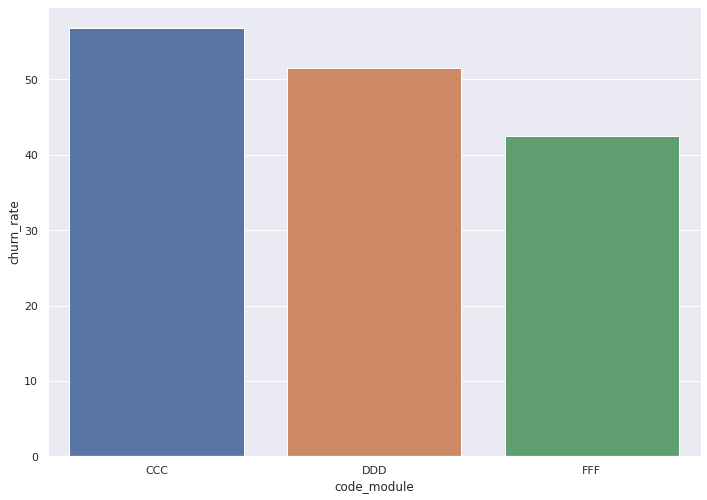

In [165]:
sns.barplot(data = top_3_churn, x = 'code_module', y = 'churn_rate')

Самый большой оток у предметов ССС (57%), DDD (52%) и FFF (43%). Наименьший отток у предметов GGG (25%) и ААА (23%)

# Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов

In [167]:
#Поскольку завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен буду использовать дф с экзаменами
exams.head()


id_assessment  id_student  date_submitted  is_banked  score  \
52923          24290      558914             230          0   32.0   
52924          24290      559706             234          0   78.0   
52925          24290      559770             230          0   54.0   
52926          24290      560114             230          0   64.0   
52927          24290      560311             234          0  100.0   

      code_module code_presentation assessment_type  date  weight  is_passed  
52923         CCC             2014B            Exam   NaN   100.0          0  
52924         CCC             2014B            Exam   NaN   100.0          1  
52925         CCC             2014B            Exam   NaN   100.0          1  
52926         CCC             2014B            Exam   NaN   100.0          1  
52927         CCC             2014B            Exam   NaN   100.0          1

In [168]:
#Посчитаю общее количество попыток сдать экзамен

all_tries_pres = (exams.groupby(['code_presentation'], as_index = False)
                  .agg(count_all = ('id_assessment', 'count'))
                  .sort_values('count_all', ascending = False)
            )
all_tries_pres



code_presentation  count_all
3             2014J       2118
2             2014B       1271
1             2013J        968
0             2013B        602

In [169]:
#Успешные сдачи экзаменов
successful_tries_pres = (exams.query("is_passed == 1")
                         .groupby(['code_presentation'], as_index = False)
                         .agg(count_successful = ('id_assessment', 'count'))
                         .sort_values('count_successful', ascending = False)
                    )
successful_tries_pres



code_presentation  count_successful
3             2014J              1861
2             2014B              1149
1             2013J               878
0             2013B               504

In [171]:

#Соединяю данные в один дф 
completion_pres = all_tries_pres.merge(successful_tries_pres, how = 'left', on = ['code_presentation'])
completion_pres.head()

code_presentation  count_all  count_successful
0             2014J       2118              1861
1             2014B       1271              1149
2             2013J        968               878
3             2013B        602               504

In [172]:
#Рассчитаю завершаемость для каждого курса
completion_pres['completion'] = completion_pres.count_successful / completion_pres.count_all

completion_pres

code_presentation  count_all  count_successful  completion
0             2014J       2118              1861    0.878659
1             2014B       1271              1149    0.904013
2             2013J        968               878    0.907025
3             2013B        602               504    0.837209

In [173]:
avg_date_submitted_pres = exams.groupby('code_presentation', as_index= False) \
                               .agg(date_mean = ('date_submitted', 'mean'))
avg_date_submitted_pres

code_presentation   date_mean
0             2013B  230.179402
1             2013J  239.505165
2             2014B  232.988985
3             2014J  243.674221

In [174]:
#Джоиню 

completion_pres = completion_pres.merge(avg_date_submitted_pres, how = 'left', on = 'code_presentation')
completion_pres

code_presentation  count_all  count_successful  completion   date_mean
0             2014J       2118              1861    0.878659  243.674221
1             2014B       1271              1149    0.904013  232.988985
2             2013J        968               878    0.907025  239.505165
3             2013B        602               504    0.837209  230.179402

Минимальной завершаемостью обладает семестр 2013B, а самое долгой сдачей семестр 2014J

# RFM-кластеры студентов

R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен.

In [ ]:
#Поскольку речь идет об экзаменах, то в качестве основы будут использовать датасет с экзаменами
exams.head()

In [ ]:
#Как я смотрел уже ранее, нет студентов, которые бы сдавали один экзамен несколько раз. 
#Перепроверю еще раз на всякий случай

exams.groupby(['code_presentation', 'code_module', 'id_student'], as_index = False) \
     .agg(exams_count = ('id_assessment', 'count')) \
     .sort_values('exams_count', ascending = False)


А если взять по предметам ?

In [ ]:
exams.groupby(['code_module', 'id_student'], as_index = False) \
     .agg(exams_count = ('id_assessment', 'count')) \
     .sort_values('exams_count', ascending = False) 



Да, есть студенты, которые сдавали один и тот же предмет, но в разных модулях. Однако нужно взять среднее время сдачи и оценку ОДНОГО ЭКЗАМЕНА. Поэтому я все-таки буду брать с разбивкой по модулям. Тем более, я предполагаю, что курсы в рамках модулей отличаются и сравнивать их будет немного некорректно.


In [ ]:
#Приступаю к RFM
#Сначала рассчитаю среднее время сдачи одного экзамена
#date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

rfm = exams.groupby(['id_student'], as_index = False) \
         .agg(submitted_mean = ('date_submitted', 'mean')) \
         .sort_values('submitted_mean', ascending = False)
rfm

In [ ]:
#Для завершаемости нужно взять количество успешных экзаменов и разделить на количество всех попыток сдать экзамен
#Реализую это через простой джоин двух датафреймов, хотя можно и развернуть сводную таблицу


#Беру только успешные экзамены студента
successful_df = exams.query("is_passed == 1") \
         .groupby(['id_student'], as_index = False) \
         .agg(successful_assessment = ('id_assessment', 'count')) \
         .sort_values('successful_assessment', ascending = False)

#Беру все экзамены, которые сдавал студент
all_exams_df = exams.groupby(['id_student'], as_index = False) \
         .agg(all_assessments = ('id_assessment', 'count')) \
         .sort_values('all_assessments', ascending = False)

#Джоиню в один дф 

f_df = successful_df.merge(all_exams_df, how = 'left', on = 'id_student')
f_df.head()


In [ ]:
#Рассчитаю завершаемость

f_df['completion'] = f_df.successful_assessment / f_df.all_assessments
f_df.query('completion != 1').count()

Из всего датафрейма всего 28 студентов не сдали какой-либо экзамен. Скорре всего, курсы не слишком сложные :)

In [ ]:
#Окей, у нас есть завершаемость. Приджоиню ее к датафрейму, в котором я рассчитываю rfm
f_df.head()

In [ ]:
#Возьму только ['id_student', 'completion']. Остальные колонки не очень нужны
rfm = rfm.merge(f_df[['id_student', 'completion']], how = 'left', on = 'id_student')
rfm.head()

In [ ]:
#Остался M - среднее количество баллов, получаемое за экзамен. Буду брать и успешные, и провальные попытки

m_df = exams.groupby(['id_student'], as_index = False) \
         .agg(score_mean = ('score', 'mean')) \
         .sort_values('score_mean', ascending = False)
m_df

Есть студенты, которые не получили ни одного балла за экзамен. Их можно отнести к оттоку (невозможно не получить ни одного балла из ста на экзамене), но все же оставлю в дф, т.к считаю, что для сегментации это полезная информация.

In [ ]:
#Посмотрю на них в первоначальном дф
exams.query("id_student == 556660")

In [ ]:
#И в дф, в котором рассчитываю rfm

rfm.query("id_student == 556660")

In [ ]:
#Как можно заметить, завершаемости у таких студентов тоже нет. Заполню нулем
#Также довольно много студентов, у которых была 1 неудачная попытка сдать экзамен. У них в колонке completion тоже null

rfm.completion = rfm.completion.fillna(0)

In [ ]:
rfm.isnull().sum()

In [ ]:
#Джоиню средний балл за экзамен

rfm = rfm.merge(m_df, how = 'left', on = 'id_student')

In [ ]:
rfm.head()

In [ ]:
#Теперь можно приступать к рассчтеу rfm scores
#Чем раньше сдал экзамен, тем больше score

rfm['r'] = 5 - (pd.qcut(rfm['submitted_mean'],4,labels=False) + 1)

rfm

In [ ]:
#Бакеты получились не совсеми равными. Надо проверить нет ли студентов, которые сразу в нескольких группах
rfm.groupby('r')['submitted_mean'].agg(['mean','count'])

In [ ]:
# Надо проверить нет ли студентов, которые сразу в нескольких группах

rfm.groupby('id_student', as_index = False) \
    .agg({'r':'count'}) \
    .sort_values('r', ascending = False) \
    .head()

Таких нет, это хорошо, продолжаю рассчитывать скоры

In [ ]:
#f-score.  pd.qcut Тут уже не сработает( Придется делать вручную

rfm.completion.value_counts() #Как видно, разделить на 4 бакета не получится, поэтому у меня не будет тройки

In [ ]:
def get_f(x):
    if x == 1:
        return 4
    if x == 0:
        return 1
    if x == 0.5: #Буду считать, что если сдан один экзамен из двух, то это медианный результат => f-score = 2 
        return 2
    return 3 

In [ ]:
rfm['f'] = rfm.completion.apply(get_f)

In [ ]:
rfm.head()

In [ ]:
rfm.groupby('f')['completion'].agg(['mean','count'])

In [ ]:
rfm.groupby('id_student', as_index = False) \
    .agg({'f':'count'}) \
    .sort_values('f', ascending = False) \
    .head()

In [ ]:
#m-score

rfm['m'] = (pd.qcut(rfm['score_mean'],4,labels=False) + 1)

In [ ]:
rfm.head()

In [ ]:
#m-score получился идеально распределенным по бакетам
rfm.groupby('m')['score_mean'].agg(['mean','count'])

In [ ]:
#Теперь получим rfm 
rfm['rfm'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm.head()

Так как rfm score дает нам 64 сегмента, я пойду немного другим путем. Я рассчитаю rfm как r + f + m  и разделю этот результат на следующие сегменты:
    1. Can\'t Loose Them
    2. Champions
    3. Loyal
    4. Potential
    5. Promising
    6. Needs Attention
    7. Require Activation

In [ ]:
rfm['rfm_score'] = (rfm.r + rfm.f + rfm.m) 

In [ ]:
#Отлично, все получилось.
rfm.head()

In [ ]:
#Функция, которая сегментирует клиентов. 

def rfm_level(x):
    if x >= 9:
        return 'Can\'t Loose Them'
    elif ((x >= 8) and (x < 9)):
        return 'Champions'
    elif ((x >= 7) and (x < 8)):
        return 'Loyal'
    elif ((x >= 6) and (x < 7)):
        return 'Potential'
    elif ((x >= 5) and (x < 6)):
        return 'Promising'
    elif ((x >= 4) and (x < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

Источник: https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17

In [ ]:
rfm['segment'] = rfm.rfm_score.apply(rfm_level)

In [ ]:
rfm.head()

In [ ]:
rfm['segment'].value_counts(normalize=True) * 100

In [ ]:
rfm.query("segment == 'Promising'")

In [ ]:
segments = rfm.groupby('segment', as_index = False) \
              .agg(students = ('id_student', 'nunique')) 
              

In [ ]:
sns.barplot(data = segments, x = 'segment', y = 'students')

Выводы по сегментации:

Подавляющее большинство студентов (около 77%) - прилежные ученики. Они успешно сдают экзамены и получают на них неплохие баллы. 

Около 15% наших учеников сдают экзамены, но на проходные-средние баллы.

Примерно 8% учеников требуют нашего повышенного внимания. Они начинают проходить курсы, но не справляются с ними, либо перестают заниматься самостоятельно. 